In [57]:
import asyncio
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
from sqlalchemy.future import select
from statsmodels.api import OLS
import pandas as pd
from sqlalchemy import case, func
from fleecekmbackend.db.models import Author, Answer, Rating
from fleecekmbackend.core.config import DATABASE_URL
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Setting up the async engine and session
engine = create_async_engine(DATABASE_URL, echo=False)
async_session = sessionmaker(engine, expire_on_commit=False, class_=AsyncSession)

async def fetch_data(model_name, sample_size=50):
    async with async_session() as session:
        # Define a subquery for authors using the specific model
        author_subquery = select(Author.id).where(Author.model == model_name).subquery()

        # Define a subquery for questions having both 'ic' and 'zs' answers from the same author
        answer_subquery = select(Answer.question_id).join(
            author_subquery, Answer.author_id == author_subquery.c.id
        ).group_by(
            Answer.question_id, Answer.author_id
        ).having(
            func.count(Answer.id) >= 2,  # Assuming at least one 'ic' and one 'zs'
            func.sum(case((Answer.setting == 'ic', 1), else_=0)) > 0,
            func.sum(case((Answer.setting == 'zs', 1), else_=0)) > 0
        ).subquery()

        main_query = (select(Answer.question_id, Answer.setting, Rating.value)
                        .join(Rating, Answer.id == Rating.answer_id)
                        .join(answer_subquery, Answer.question_id == answer_subquery.c.question_id)
                        .select_from(Answer)
                        .order_by(Answer.question_id))

        # Main query to select answers and their ratings
        results_ic = await session.execute(
            main_query.where(Answer.setting == 'ic').limit(sample_size)
        )
        results_zs = await session.execute(
            main_query.where(Answer.setting == 'zs').limit(sample_size)
        )
        return results_ic.all() + results_zs.all()

def prepare_data(data):
    # Create a DataFrame
    df = pd.DataFrame(data, columns=['question_id', 'setting', 'rating_value'])
    
    # Convert 'setting' to a binary indicator variable for regression analysis
    df['setting_ind'] = df['setting'].apply(lambda x: 1 if x == 'ic' else 0)
    return df

async def analyze_model(model_name):
    data = await fetch_data(model_name)
    prepared_data = prepare_data(data)
    
    # Perform regression analysis
    Y = prepared_data['rating_value']
    X = prepared_data[['setting_ind']]
    X = sm.add_constant(X)  # adding a constant
    model = OLS(Y, X).fit()
    print(f"Regression Analysis for {model_name}")
    print(model.summary())
    return model, prepared_data


In [58]:
gpt_4_regression_model, gpt_4_data = await analyze_model('gpt-4-turbo')

Regression Analysis for gpt-4-turbo
                            OLS Regression Results                            
Dep. Variable:           rating_value   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     34.15
Date:                Tue, 07 May 2024   Prob (F-statistic):           6.69e-08
Time:                        19:04:27   Log-Likelihood:                -154.56
No. Observations:                 100   AIC:                             313.1
Df Residuals:                      98   BIC:                             318.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         

In [59]:
llama3_regression_model, llama3_data = await analyze_model("meta-llama/Meta-Llama-3-70B-Instruct")

Regression Analysis for meta-llama/Meta-Llama-3-70B-Instruct
                            OLS Regression Results                            
Dep. Variable:           rating_value   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     62.28
Date:                Tue, 07 May 2024   Prob (F-statistic):           4.32e-12
Time:                        19:04:49   Log-Likelihood:                -164.56
No. Observations:                 100   AIC:                             333.1
Df Residuals:                      98   BIC:                             338.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

[[0.993248 0.906157 0.143936 1.      ]
 [0.369214 0.788888 0.382914 1.      ]
 [0.127568 0.566949 0.550556 1.      ]
 [0.229739 0.322361 0.545706 1.      ]
 [0.267004 0.004874 0.329415 1.      ]]


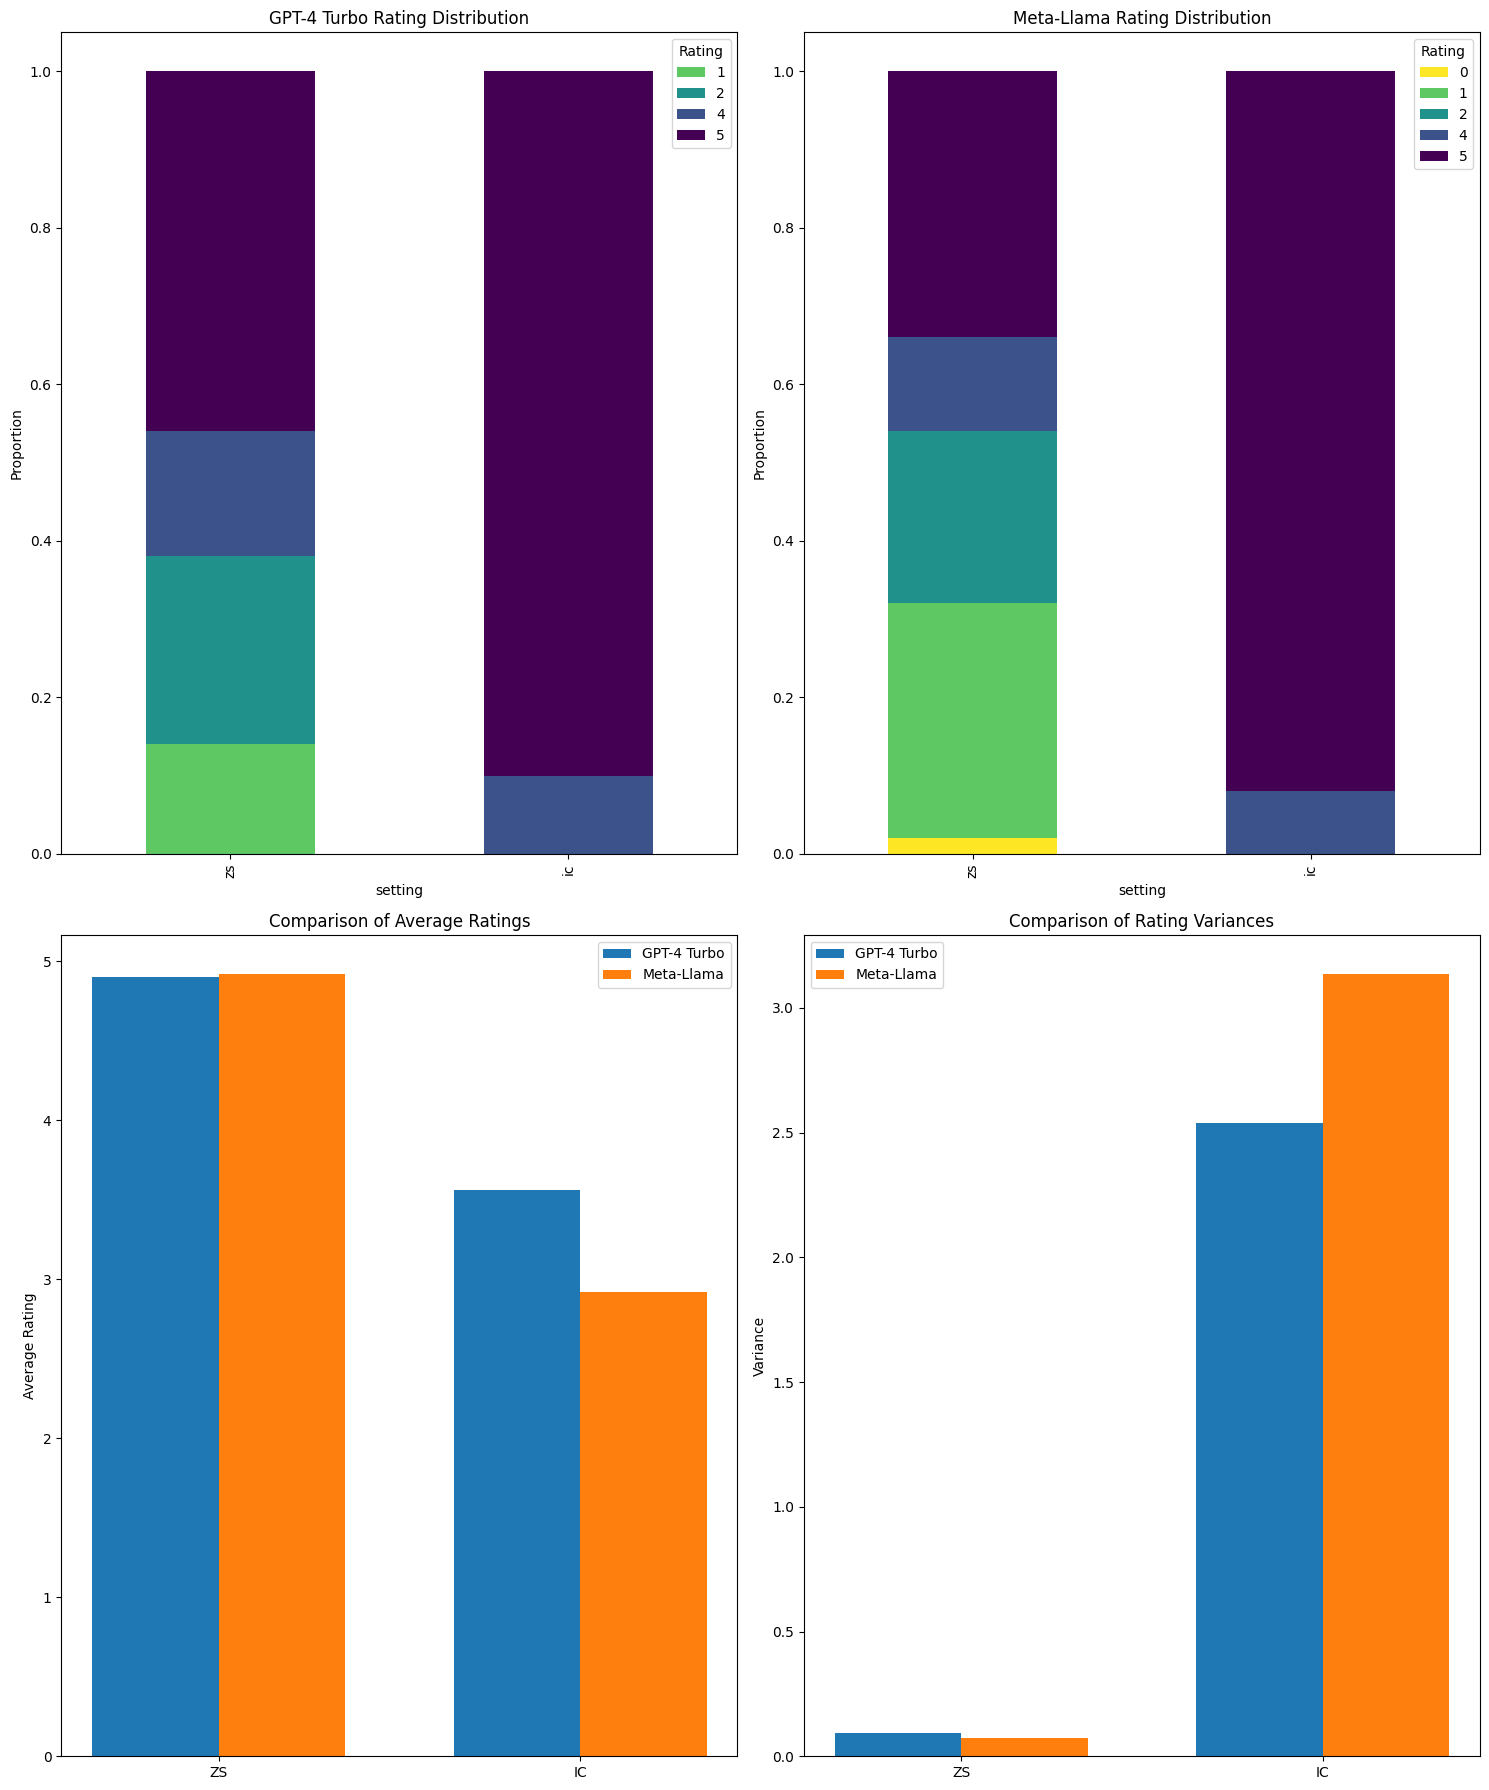

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


async def plot_model_results(model_gpt, data_gpt, model_meta, data_meta):
    # Prepare figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 18))

    # Colors aligned across models
    colors = plt.cm.viridis(np.linspace(1, 0, len(data_meta['rating_value'].unique())))

    print(colors)

    # Normalize and plot 100% Stacked Bar Chart for GPT-4 Turbo
    gpt_counts = data_gpt.groupby(['setting', 'rating_value']).size().unstack(fill_value=0)
    gpt_proportions = gpt_counts.divide(gpt_counts.sum(axis=1), axis=0)
    gpt_proportions.sort_index(ascending=False).plot(kind='bar', stacked=True, color=colors[1:], ax=axes[0, 0])
    axes[0, 0].set_title('GPT-4 Turbo Rating Distribution')
    axes[0, 0].set_ylabel('Proportion')
    axes[0, 0].legend(title='Rating')

    # Normalize and plot 100% Stacked Bar Chart for Meta-Llama
    meta_counts = data_meta.groupby(['setting', 'rating_value']).size().unstack(fill_value=0)
    meta_proportions = meta_counts.divide(meta_counts.sum(axis=1), axis=0)
    meta_proportions.sort_index(ascending=False).plot(kind='bar', stacked=True, color=colors, ax=axes[0, 1])
    axes[0, 1].set_title('Meta-Llama Rating Distribution')
    axes[0, 1].set_ylabel('Proportion')
    axes[0, 1].legend(title='Rating')

    # Bar graph of average ratings
    gpt_means = data_gpt.groupby('setting')['rating_value'].mean()
    meta_means = data_meta.groupby('setting')['rating_value'].mean()
    index = np.arange(2)
    bar_width = 0.35
    axes[1, 0].bar(index, gpt_means, bar_width, label='GPT-4 Turbo')
    axes[1, 0].bar(index + bar_width, meta_means, bar_width, label='Meta-Llama')
    axes[1, 0].set_title('Comparison of Average Ratings')
    axes[1, 0].set_xticks(index + bar_width / 2)
    axes[1, 0].set_xticklabels(['ZS', 'IC'])
    axes[1, 0].set_ylabel('Average Rating')
    axes[1, 0].legend()

    # Bar graph of rating variances
    gpt_variances = data_gpt.groupby('setting')['rating_value'].var()
    meta_variances = data_meta.groupby('setting')['rating_value'].var()
    axes[1, 1].bar(index, gpt_variances, bar_width, label='GPT-4 Turbo')
    axes[1, 1].bar(index + bar_width, meta_variances, bar_width, label='Meta-Llama')
    axes[1, 1].set_title('Comparison of Rating Variances')
    axes[1, 1].set_xticks(index + bar_width / 2)
    axes[1, 1].set_xticklabels(['ZS', 'IC'])
    axes[1, 1].set_ylabel('Variance')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


await plot_model_results(gpt_4_regression_model, gpt_4_data, llama3_regression_model, llama3_data)
